# Two challenge problems for Brownian motion of the Hopf fibration

**Authors:** Stephen Marsland and Klas Modin


## Introduction

By numerical computations we explore horizontal Brownian motion and stochastic gradient flows relative to the Hopf fibration. The study of this problem is motivated by an infinite-dimensional analogue, where the Hopf fibration is replaced by Moser's fibration of $\mathrm{Diff}(M)$ as an $\mathrm{SDiff}(M)$ bundle over the space $\mathrm{Dens}(M)$ of probability densities.

### Installation

To run this notebook you need recent versions of `numpy`, `scipy`, `matplotlib`, and `numba`. In addition, you need the [quaternion module](https://github.com/moble/quaternion). 
If you are using `conda` it is easily installed with
```
conda install -c conda-forge quaternion
``` 
or for `pip` users
```
pip install --user numpy numpy-quaternion
```

## The Hopf fibration: a crash course

TODO

In [1]:
import numpy as np
import scipy
import quaternion 

def hopf(z):
    return 0.25*z*np.quaternion(0,0,0,1)*z.conj()

## Stochastic motion on $S^2$

Our horizontal Brownian motion on the unit quaternions $S^3$ is generated by horizontal lifting of a uniform Brownian motion on $S^2$. Thus, the first step is to generate a (standard) Brownian motion on $S^2$.

The form of our stochastic flow is
$$
    d \mathbf r = -\nabla f(\mathbf r)d t + dW
$$
where $\mathbf r\in S^2\subset \mathbb{R}^3$ and $f$ is a $C^2$ function on $S^2$.
We start by generating the gradient function and the noise. 
Notice that we generate the noise as standard Gaussian in $\mathbb{R}^3$.
The corresponding noise vector at $T_\mathbf r S^2$ is given by orthogonal projection onto the plane defined by $\mathbf r$.

As a first step, let us consider in this notebook the pure random walk when $f=0$.

In [2]:
# Set total simulation time, stepsize, and total number of runs
totaltime = 0.2048
stepsize = 1e-4
Nruns = 512

# Compute number of steps
Nsteps = int(totaltime/stepsize)
print('Total number of steps: '+str(Nsteps))
totaltime = Nsteps*stepsize # adjust totaltime

# Compute time vector
t = stepsize*np.arange(Nsteps,dtype=float)

# Define gradient term, weighted by alpha
alpha = 0.0
north_pole = np.array([0.,0.,1.])
def gradf(r):
    f = alpha*(north_pole-r)
    f = f - (np.sum(f*r,axis=1)*r.T).T
    return f

# Generate random vectors dW in R^3
dW = np.random.normal(scale=np.sqrt(stepsize),size=(Nruns,Nsteps,3))

Total number of steps: 2048


We can now generate the stochastic motion on $S^2$.
For simplicity we use Euler's explicit method along geodesics (great circles).
A more sophisticated integrator would be the *Riemannian midpoint method* as developed in [this paper](http://dx.doi.org/10.1007/s00332-016-9311-z).
Initial positions are given by the north pole $\mathbf r_0 = (0,0,1)$.

In [3]:
%%time

# Allocate position and velocity arrays
r = np.zeros((Nruns,Nsteps,3),dtype=float)
v = np.zeros_like(r)

# Set initial positions
r[:,0,:] = np.array([0.,0.,1.])

# Main integration loop
for k in range(Nsteps-1):
    
    # Project dW onto tangent plane at r to get the stochastic velocity vector
    v[:,k,:] = dW[:,k,:] - (dW[:,k,:]*r[:,k,:]).sum(axis=-1)[:,np.newaxis]*r[:,k,:]
    
    # Add gradient term
    v[:,k,:] += stepsize*gradf(r[:,k])
    
    # Take one step of geodesic motion, i.e., along a great circle
    theta = np.sqrt((v[:,k,:]**2).sum(axis=-1))[:,np.newaxis]
    r[:,k+1,:] = np.cos(theta)*r[:,k,:] + (v[:,k,:]/theta)*np.sin(theta)

CPU times: user 687 ms, sys: 22.1 ms, total: 709 ms
Wall time: 708 ms


To verify that everything looks good we plot the generated points at the end time.

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({'font.size': 14})

def plot_sphere(ax, radius=1.):
    """Function for plotting a wireframe of the 2-sphere."""
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    factor = 1.0
    x = factor*np.cos(u)*np.sin(v)
    y = factor*np.sin(u)*np.sin(v)
    z = factor*np.cos(v)
    ax.plot_wireframe(x, y, z, color=(0.8,0.8,0.8)) 

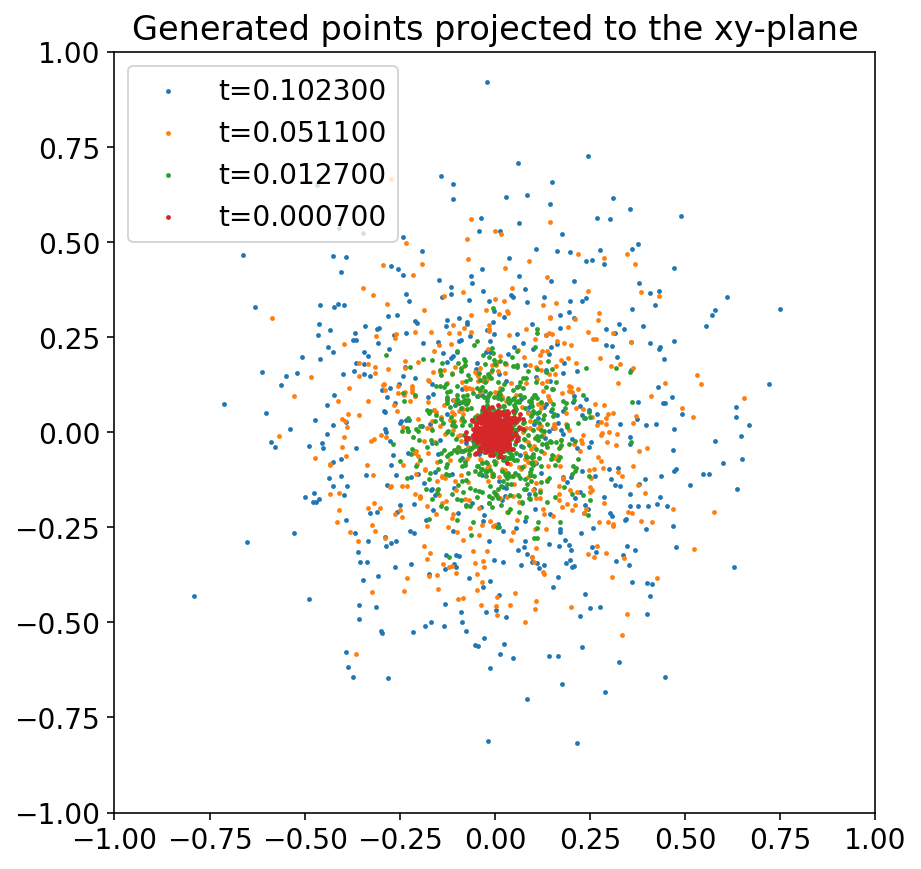

In [9]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

# Select time indices to plot
timeind = np.array([Nsteps//256,Nsteps//16,Nsteps//4,Nsteps//2])-1

# Plot generated points projeced onto the xy-plane
for k in timeind[::-1]:
    ax.scatter(r[:,k,0], r[:,k,1], s=2, label='t={:f}'.format(t[k]))
ax.set_xlim([-1,1]); ax.set_ylim([-1,1])
ax.set_title('Generated points projected to the xy-plane')
ax.legend()
ax.set_aspect(1);
plt.show()

Notice how the points are initially clustered around the origin (north pole) but tending to spread out to fill the entire sphere. 
To understand the diffusion better we compute the distance of each of the points to the north pole, and we look at the corresponding time series.
For small $t$ we expect the average to approximatelly behave as $\sqrt{t}$ since $S^2$ is locally an approximation of $\mathbb{R}^2$.

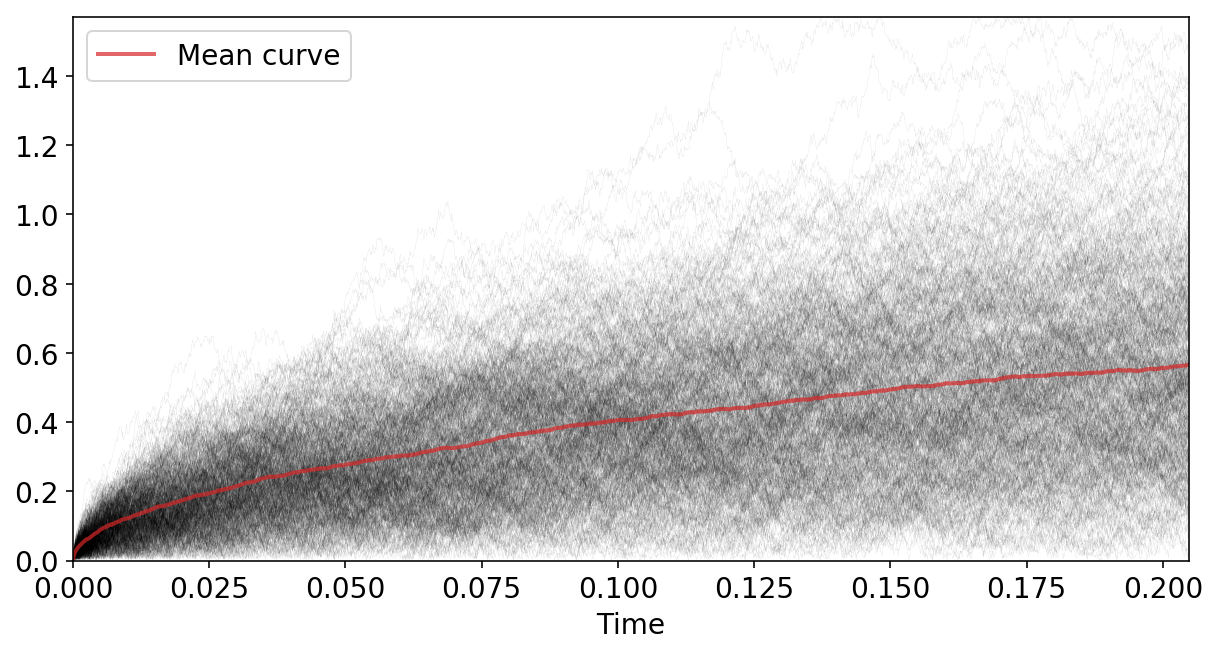

In [10]:
def distS2(r1,r2,radius=1.0):
    """Geodesic distance between points on S^2."""
    d1 = np.arccos((1./radius)**2*(r1*r2).sum(axis=-1))*radius
    d2 = np.arccos((1./radius)**2*(-r1*r2).sum(axis=-1))*radius
    return np.nanmin([d1,d2],axis=0)

# Compute distances to the north pole
dist_to_north_pole = distS2(r,north_pole)

# Plot time series
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
for d in dist_to_north_pole:
    ax.plot(t,d,color='k',alpha=0.2,linewidth=0.1)
ax.plot(t,np.mean(dist_to_north_pole,axis=0),linewidth = 2.,color='tab:red',alpha=0.7,label='Mean curve')
ax.set_xlim([0,totaltime])
ax.set_ylim([0,np.max(dist_to_north_pole)])
ax.set_xlabel('Time')
ax.legend()
plt.show()

Notice how the average curve looks very much like $\sqrt t$, but let us test this by fitting it to a function of the form
$$
    f(t) = c t^\gamma.
$$

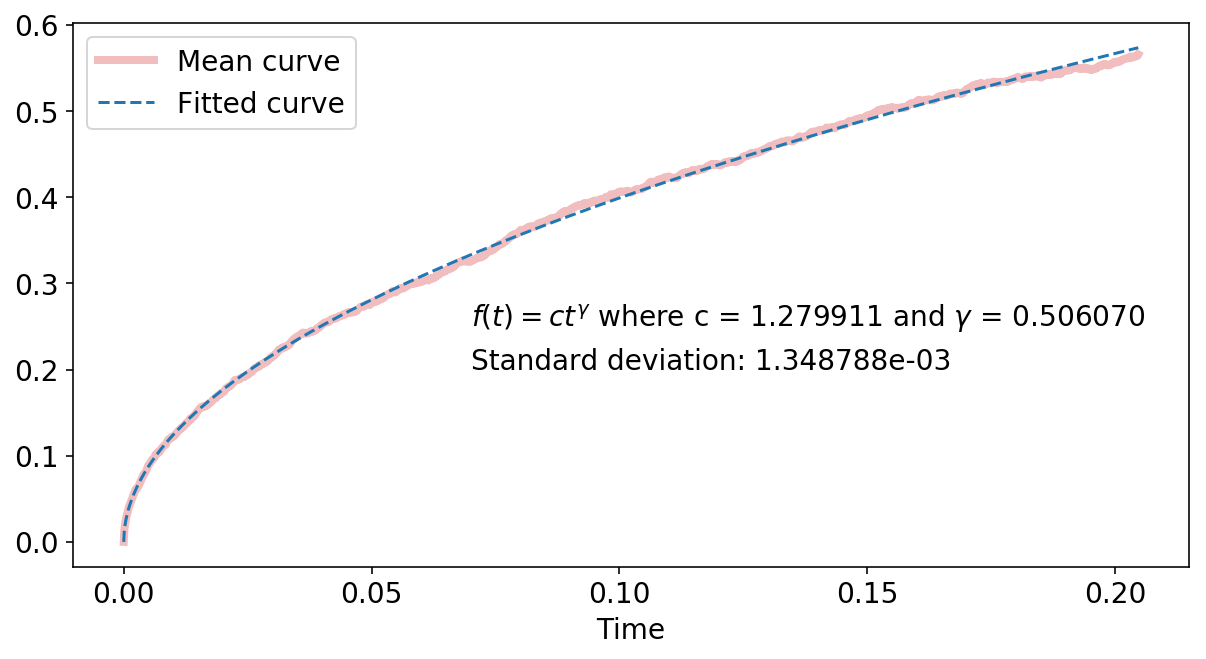

In [11]:
from scipy.optimize import curve_fit

# Define function form with parameters
def func(t,c,gamma):
    return c*t**gamma

# Do the curve fitting and extract the estimated parameter c
ydata = np.mean(dist_to_north_pole,axis=0)
popt, pcov = curve_fit(func, t, ydata, p0=(1.,0.5))
c = popt[0]
gamma = popt[1]

# Plot the data and the fitted curve
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.plot(t, ydata,linewidth=4,alpha=0.3,label='Mean curve',color='tab:red')
ax.plot(t,func(t,c,gamma),'--',label='Fitted curve',color='tab:blue')
ax.set_xlabel('Time')
ax.text(0.07,0.25,'$f(t) = c t^\gamma$ where c = {:f} and $\gamma$ = {:f}'.format(c,gamma))# {:e}'.format(c))
ax.text(0.07,0.2,'Standard deviation: {:e}'.format(np.sqrt(pcov[0,0])))
ax.legend()
plt.show()

The fit is quite good, especially for small $t$. Notice that it should not be perfectly $\gamma=1/2$, since the sphere is different from Euclidean space (in particular, there is a maximum distance between points).

### First challenge (warm up):

### What is the theoretical diffusion curve for Brownian motion on the sphere?

## Horizontal lift to $S^3$

TODO: show derivation of the lifting equations

In [12]:
from numba import autojit, jit, float64, int32, void, prange
import math

@jit(void(float64[:,:,:],float64[:,:,:],float64[:,:,:]),nopython=True, parallel=True)
def horlift(r,v,xi):
    """
    Horizontal lifting algorithm.
    
    Input arguments: r,v
    Output arguments: xi
    """
    Nruns, Nsteps, _ = v.shape
    
    for i in prange(Nruns):

        # Some local variables
        P = np.zeros((3,2))
        a = np.zeros(2)
        shat = np.zeros((3,3))
        
        for k in range(Nsteps-1):
            
            # Define shortcut views
            sdot = v[i,k,:]
            s = r[i,k,:]

            # Compute two basis vectors orthogonal to s as columns in P
            P[0,0] = s[2]; P[1,0] = s[2]; P[2,0] = -s[1]-s[0];
            if np.abs(P[0,0]) < 1e-10 and np.abs(P[2,0]) < 1e-10:
                P[0,0] = -s[2]-s[1]; P[1,0] = s[0]; P[2,0] = s[0];
            P[0,1] = s[1]*P[2,0] - s[2]*P[1,0]
            P[1,1] = s[2]*P[0,0] - s[0]*P[2,0]
            P[2,1] = s[0]*P[1,0] - s[1]*P[0,0]

            # Compute hat map
            shat[0,0] = 0.;    shat[0,1] = s[2];  shat[0,2] = -s[1]
            shat[1,0] = -s[2]; shat[1,1] = 0.;    shat[1,2] = s[0]
            shat[2,0] = s[1];  shat[2,1] = -s[0]; shat[2,2] = 0.

            # Define linear lifting equation to be solved
            M = np.dot(P.T,np.dot(shat,P))
            b = np.dot(P.T,sdot)

            # Solve linear 2 by 2 system using Cramer's method
            D = M[0,0]*M[1,1]-M[0,1]*M[1,0]
            Dx = b[0]*M[1,1]-M[0,1]*b[1]
            Dy = M[0,0]*b[1]-b[0]*M[1,0]
            a[0] = Dx/D
            a[1] = Dy/D
            
            # Compute the angular velocity vectors
            xi[i,k,:] = np.dot(P,a)

We can now compute the horizontally lifted velocities.
Most of the computational time is spent here.

In [13]:
%%time

# Allocate angular velocity vector array
xi = np.zeros((Nruns,Nsteps,3),dtype=float)

# Compute the horizontal lift from r and v.
horlift(r, v, xi[:,1:,:])

CPU times: user 3.32 s, sys: 9.36 ms, total: 3.33 s
Wall time: 446 ms


We now integrate using the Lie-Euler method
$$
    q_{k} = \exp(\xi_k)\cdot q_{k-1}
$$
where $\exp(\xi)$ denotes the group exponential, which is this case just corresponds to positive rotation about $\xi$ by the angle $\left|\xi\right|$.

In [14]:
%%time

# Integrate the computed horizontal vectors to yield unit quaternions
expxi = quaternion.from_rotation_vector(xi)
q = np.cumprod(expxi,axis=1)

CPU times: user 107 ms, sys: 40 ms, total: 147 ms
Wall time: 145 ms


We can now plot the generated motion. 
To do so, we first compute the rotation matrix representation $Q\in \mathrm{SO}(3)$ of $q$, and then we plot the columns of $Q$. This tells us how the rotation matrix is acting on the basis vectors $e_1=(1,0,0)$, $e_2=(0,1,0)$, $e_3=(0,0,1)$ in $\mathbb R^3$.
Recall that $q$ is determined from $Q$ up to sign ($S^3$ is a *double covering* of $\mathrm{SO}(3)$).

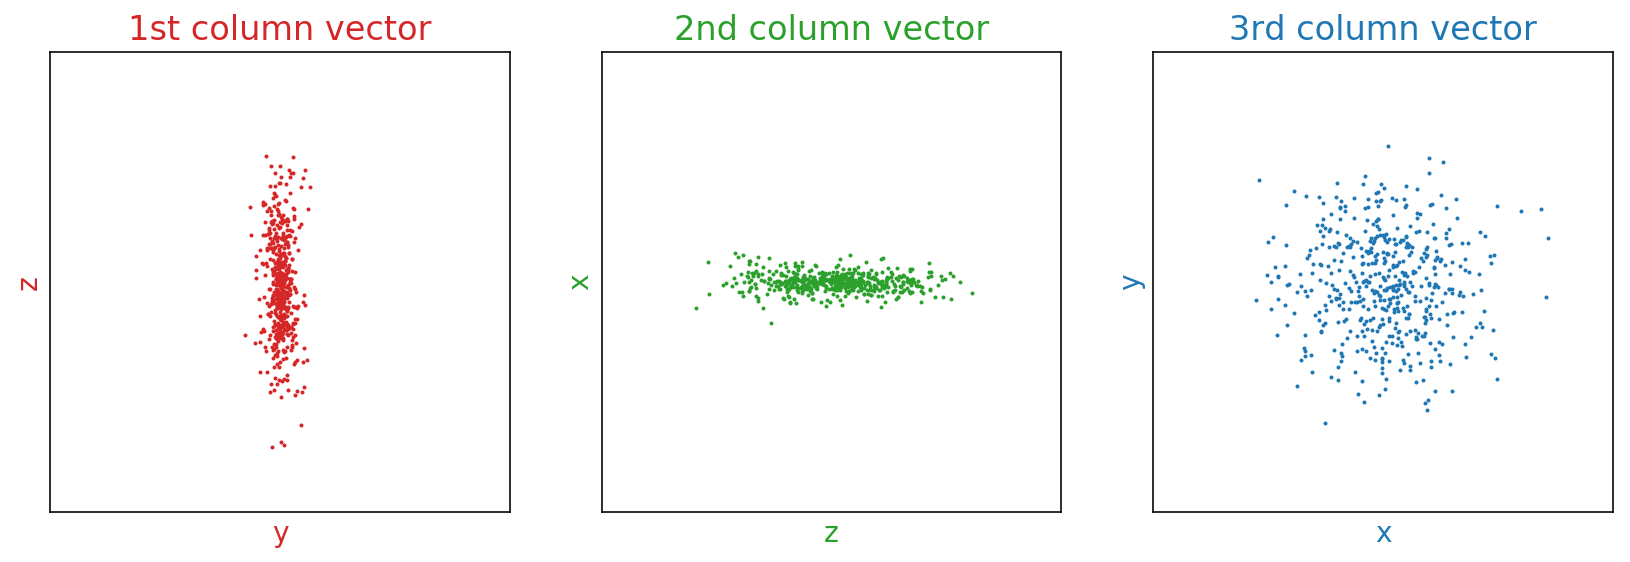

In [15]:
fig = plt.figure(figsize=(14, 6))
try:
    axs = fig.subplots(1,3,sharey=True)
except:
    ax0 = fig.add_subplot(131)
    ax1 = fig.add_subplot(132)
    ax2 = fig.add_subplot(133)
    axs = [ax0,ax1,ax2]

def plot_columns(Q,k,axs,lim=0.5):
    """Plot the column vectors of 3x3 matrices projected onto the yz-, zx-, and xy-planes."""
    
    # Select colors for each column vector
    colors = ['tab:red','tab:green','tab:blue']

    horaxes = [1,2,0]; vertaxes = [2,0,1]
    for d in range(3):
        axs[d].scatter(Q[:,k,horaxes[d],d],Q[:,k,vertaxes[d],d],s=1,color=colors[d],alpha=1)
        axs[d].set_xlim([-lim,lim]); axs[d].set_ylim([-lim,lim])
        axs[d].set_xlabel('xyz'[horaxes[d]],color=colors[d]) 
        axs[d].set_ylabel('xyz'[vertaxes[d]],color=colors[d])
        axs[d].set_aspect(1)
        axs[d].set_title(['1st','2nd','3rd'][d]+' column vector',color=colors[d])
        axs[d].set_xticks([]); axs[d].set_yticks([]);

# Convert from quaternions to rotation matrices
Q = quaternion.as_rotation_matrix(q)

# Select time index to plot
k = 128

# Make the plot
plot_columns(Q,k,axs)
plt.show()

The fiber at the identity is given by rotation about the $z$-axis, so the corresponding vertical distribution consists of infinitesimal rotations about the $z$-axis. Thus, the horizontal distribution consists of infinitesimal rotations about any axis orthogonal to the $z$-axis. One can clearly see that the 1st and 2nd column vectors prefers to diffuse in these directions. However, due to the non-integrability of the horizontal distribution one also gets a slower diffusion along the fiber direction.

To further study the horizontal behaviour of the flow, let us look at the motion of the 1st column vector for a few trajectories.

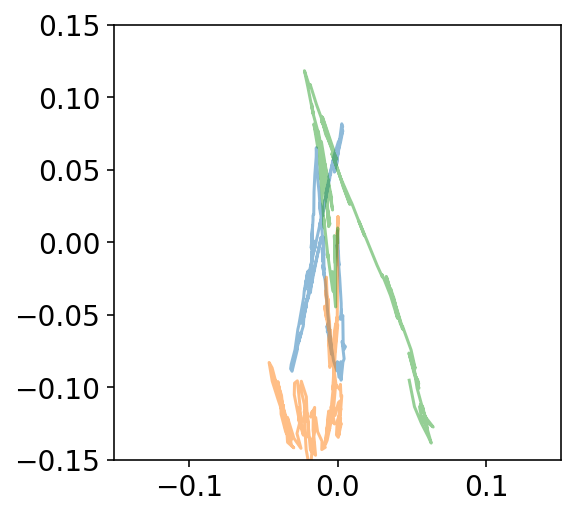

In [16]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)

# Select which trajectories to plot
ntraj = np.arange(3) # Pick the first 3 trajectories

# Plot the 1st column projected to yz-plane
ax.plot(Q[ntraj,:200,1,0].T,Q[ntraj,:200,2,0].T,alpha=0.5)
lim = 0.15
ax.set_xlim(-lim,lim);ax.set_ylim(-lim,lim);
plt.show()

Each color is a trajectory. Notice the "zig-zaging" along the horizontal directions, slowly diffusing into the fiber directions.

We now come to the question of diffusion rates. As can be seen in the plots, the diffusion rate is clearly different in the vertical and horizontal directions. In fact, the reason that we get diffusion at all in the vertical direction is because the horizontal distribution is not integrable, which in terms stems from the sphere being non-flat. 

So, to measure the diffusion in the vertical direction we need to be able to compute the "vertical distance" between two quaternions $q$ and $p$. To do so, it is easier to think of a quaternion as a rank-1 spinor, i.e., two complex numbers, via the identification $q\mapsto (z_0,z_1)=(q_0+iq_1,q_2+iq_3)$. The fiber at $(z_0,z_1)$ is then parameterized by $(e^{i\theta}z_0,e^{i\theta}z_1)$. Thus, given another spinor $(u_0,u_1)$ the vertical distance to $(z_0,z_1)$ is given by $|\theta|$, where $\theta$ minimizes the $S^3$ distance between $(u_0,u_1)$ and $(e^{i\theta}z_0,e^{i\theta}z_1)$ (this automatically also gives us the horizontal distance, which we already know by applying the Hopf map and then taking the $S^2$ distance).
Since the minimal $S^3$ distance is also the minimal $\mathbb{R}^4$ distance, it is enough to solve the minimization problem
$$
\min_{\theta} |e^{i\theta}z_0-u_0|^2 + |e^{i\theta}z_1-u_1|^2 .
$$
Extremizing this leads to
$$
e^{i\theta}(z_0\bar u_0+z_1\bar u_1)= e^{-i\theta}(\bar z_0u_0+\bar z_1u_1)
\iff Im(e^{i\theta}(z_0\bar u_0+z_1\bar u_1))=0.
$$
Thus, the extremal condition is $arg(z_0\bar u_0+z_1\bar u_1)+\theta = n\pi$.
Since in our case $p=(1,0,0,0)$ corresponding to $u_0=1$ and $u_1=0$, we simply get
$$
    arg(z_0)+\theta = n\pi.
$$
In the interval $[0,2\pi)$ this gives us two solutions corresponding to $arg(z_0)+\theta=0$ and $arg(z_0)+\theta=\pi$.

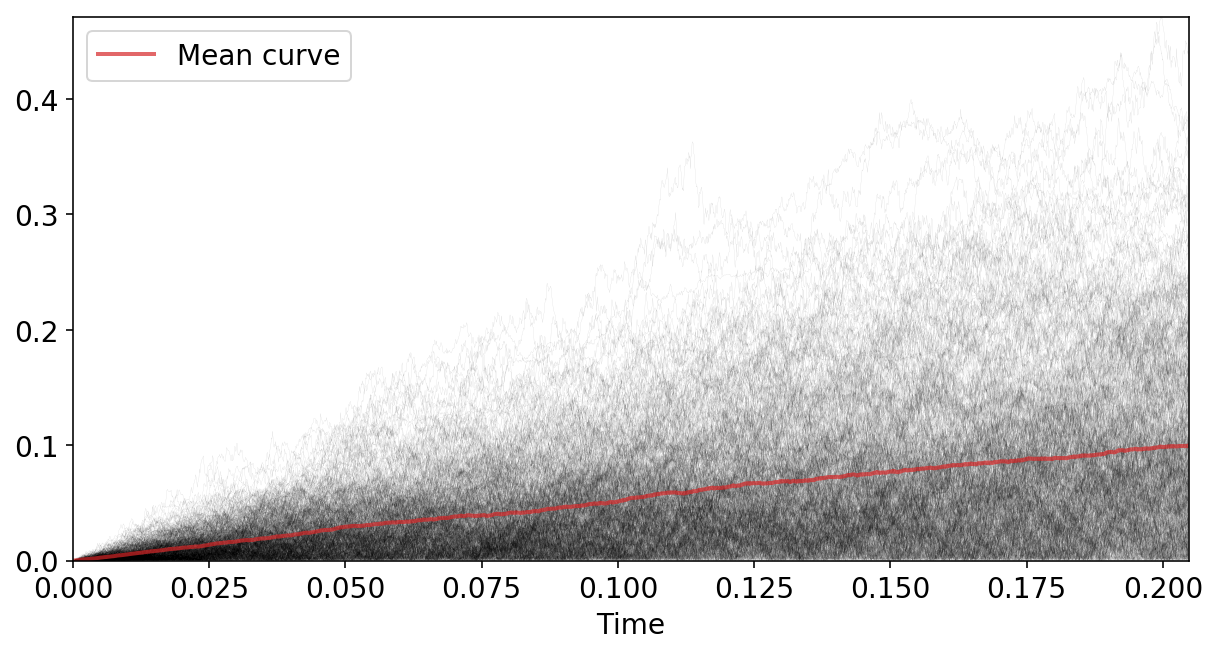

In [17]:
# Compute vertical distance between q and (1,0,0,0)
z0 = quaternion.as_spinor_array(q)[:,:,0];
vdistq = np.abs(np.angle(z0));

# Plot time series
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
for d in vdistq:
    ax.plot(t,d,color='k',alpha=0.2,linewidth=0.1)
ax.plot(t,np.mean(vdistq,axis=0),linewidth = 2.,color='tab:red',alpha=0.7,label='Mean curve')

ax.set_xlim([0,totaltime])
ax.set_ylim([0,np.max(vdistq)])
ax.set_xlabel('Time')
ax.legend()
plt.show()

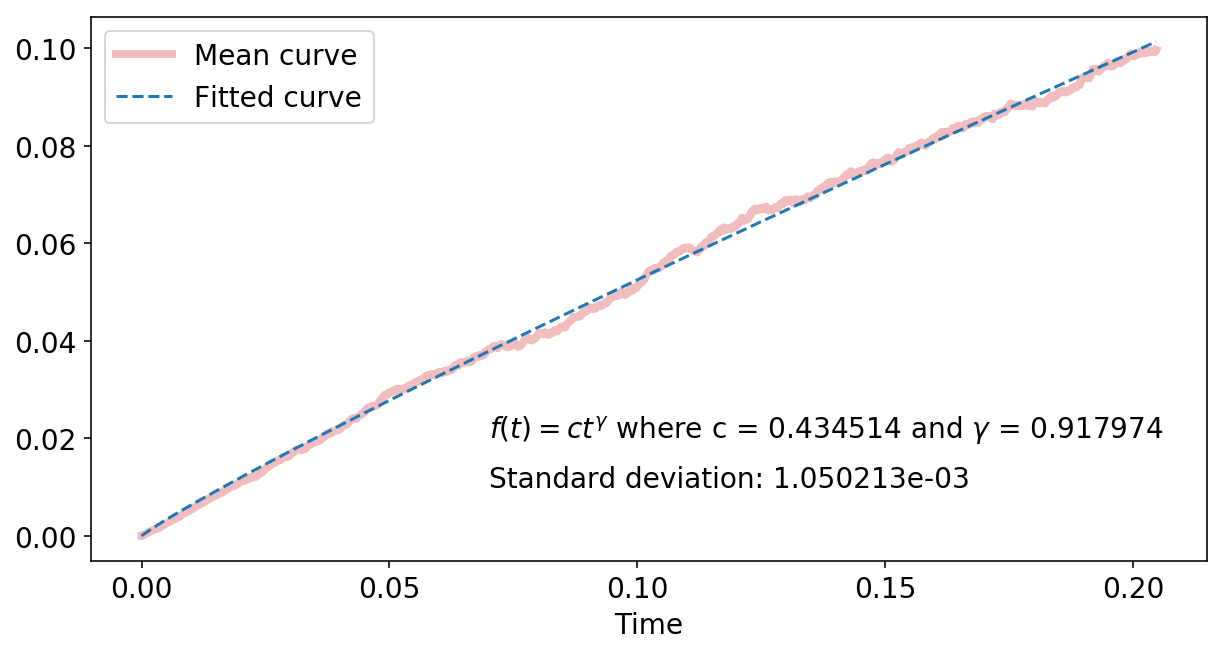

In [18]:
from scipy.optimize import curve_fit

# Define function form with parameters
def func(t,c,gamma):
    return c*t**gamma

# Do the curve fitting and extract the estimated parameter c
ydata = np.mean(vdistq,axis=0)
popt, pcov = curve_fit(func, t, ydata, p0=(1.,0.5))
c = popt[0]
gamma = popt[1]

# Plot the data and the fitted curve
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.plot(t, ydata,linewidth=4,alpha=0.3,label='Mean curve',color='tab:red')
ax.plot(t,func(t,c,gamma),'--',label='Fitted curve',color='tab:blue')
ax.set_xlabel('Time')
ax.text(0.07,0.02,'$f(t) = c t^\gamma$ where c = {:f} and $\gamma$ = {:f}'.format(c,gamma))
ax.text(0.07,0.01,'Standard deviation: {:e}'.format(np.sqrt(pcov[0,0])))
ax.legend()
plt.show()

### Second challenge (the real deal):

### What is the theoretical diffusion curve in the vertical direction of the Hopf-Brownian motion?

## Uniform stochastic motion on $S^3$

To compare with the lifted (non-uniform) stochastic motion, we also generate a uniform stochastic motion on $S^3$.

In [19]:
%%time

# Make uniform random motion on S^3.
# For simplicity we use the same random vectors dW as generated above.
expdW = quaternion.from_rotation_vector(dW)
quni = np.cumprod(expdW,axis=1)

CPU times: user 102 ms, sys: 34.3 ms, total: 137 ms
Wall time: 134 ms


We can now compare with the results we got for the non-uniform noise. Thus, we first create the rotation matrices corresponding to the generated unitary quaternions and then we plot the columns as before.

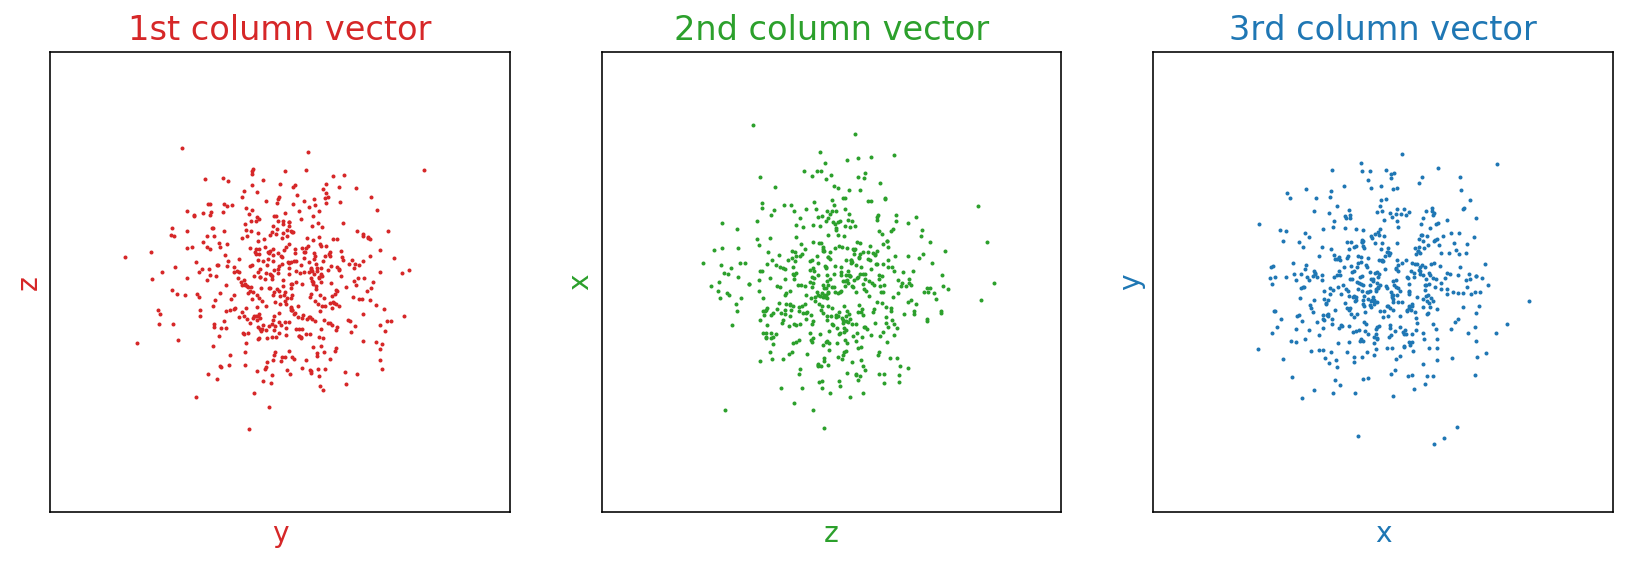

In [20]:
fig = plt.figure(figsize=(14, 6))
try:
    axs = fig.subplots(1,3,sharey=True)
except:
    ax0 = fig.add_subplot(131)
    ax1 = fig.add_subplot(132)
    ax2 = fig.add_subplot(133)
    axs = [ax0,ax1,ax2]

# Convert from quaternions to rotation matrices
Quni = quaternion.as_rotation_matrix(quni)

# Select time index to plot
k = 128

# Make the plot
plot_columns(Quni,k,axs)
plt.show()

Notice, as expected, that we have the same type of diffusion in all three column vectors, i.e., there are no prefered directions as in the non-uniform case.
Furthermore, for the trajectories below we see no "zig-zaging" behaviour as in the non-uniform case, but more like a standard random walk. An animation of the non-uniform and uniform walks looks as follows:

In [45]:
%%HTML
<video width="900" controls>
  <source src="double-walk.mp4" type="video/mp4">
</video>
<br>
<a href="https://raw.githubusercontent.com/kmodin/hopf-random-walk/master/double-walk.mp4" target="_blank">Press here</a> if the video is not showing 

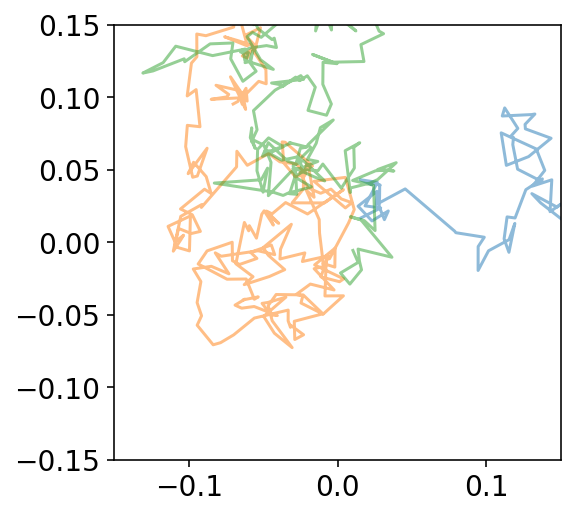

In [21]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)

# Select which trajectories to plot
ntraj = np.arange(3)

# Plot the 1st column projected to yz-plane
ax.plot(Quni[ntraj,:200,1,0].T,Quni[ntraj,:200,2,0].T,alpha=0.5)
lim = 0.15
ax.set_xlim(-lim,lim);ax.set_ylim(-lim,lim);
plt.show()

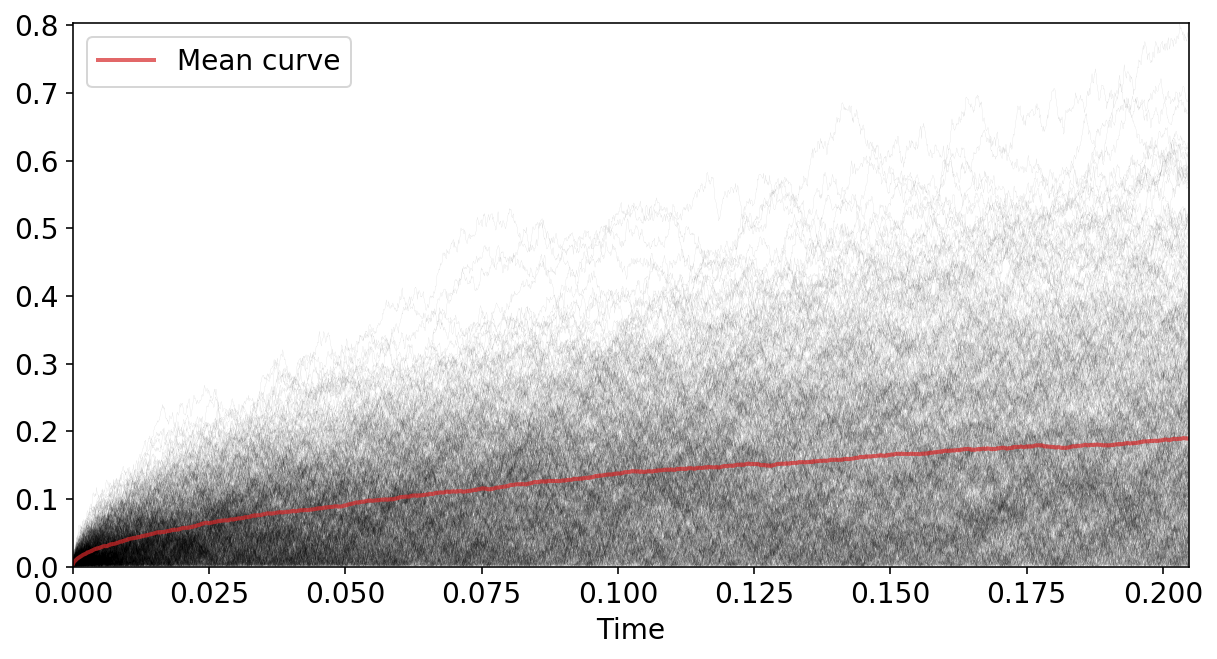

In [22]:
# Compute vertical distance between quni and (1,0,0,0)
z0uni = quaternion.as_spinor_array(quni)[:,:,0];
vdistquni = np.abs(np.angle(z0uni));

# Plot time series
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
for d in vdistquni:
    ax.plot(t,d,color='k',alpha=0.2,linewidth=0.1)
ax.plot(t,np.mean(vdistquni,axis=0),linewidth = 2.,color='tab:red',alpha=0.7,label='Mean curve')

ax.set_xlim([0,totaltime])
ax.set_ylim([0,np.max(vdistquni)])
ax.set_xlabel('Time')
ax.legend()
plt.show()

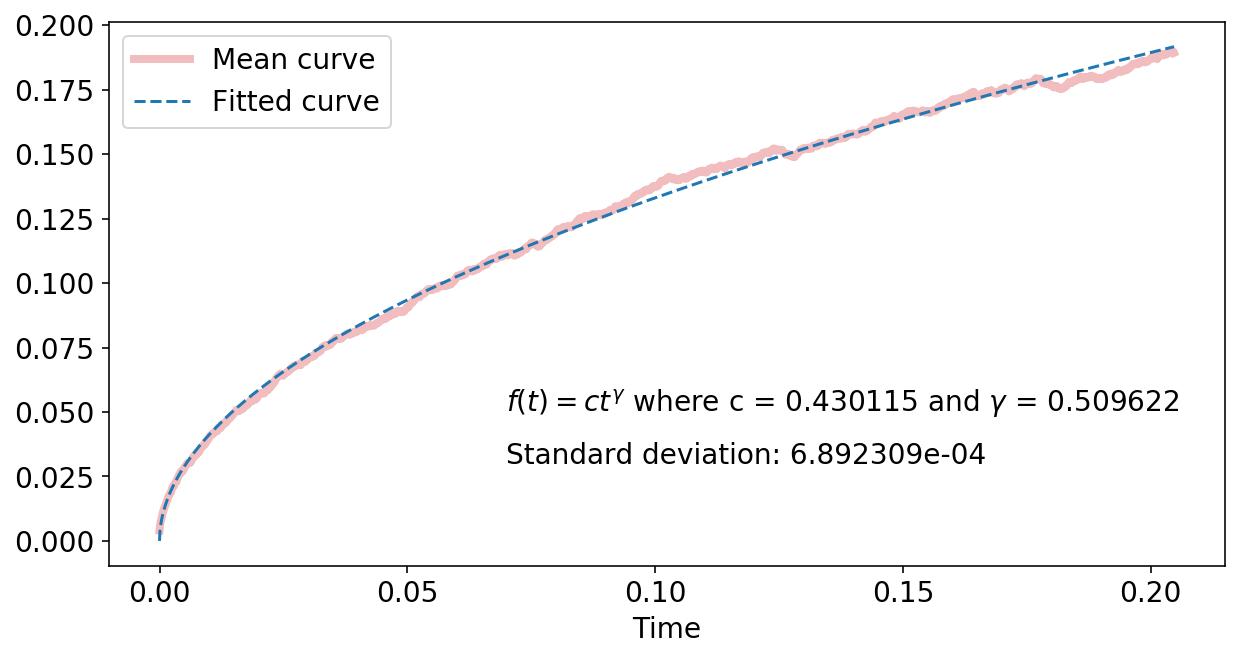

In [23]:
# Do the curve fitting and extract the estimated parameters
ydata = np.mean(vdistquni,axis=0)
popt, pcov = curve_fit(func, t, ydata, p0=(1.,0.5))
c = popt[0]
gamma = popt[1]

# Plot the data and the fitted curve
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.plot(t, ydata,linewidth=4,alpha=0.3,label='Mean curve',color='tab:red')
ax.plot(t,func(t,c,gamma),'--',label='Fitted curve',color='tab:blue')
ax.set_xlabel('Time')
ax.text(0.07,0.05,'$f(t) = c t^\gamma$ where c = {:f} and $\gamma$ = {:f}'.format(c,gamma))
ax.text(0.07,0.03,'Standard deviation: {:e}'.format(np.sqrt(pcov[0,0])))
ax.legend()
plt.show()

Notice that $\gamma$ is close to $1/2$ (but not exactly since we are on a sphere) as expected in the uniform case.

To further compare between the non-uniform and the uniform random walks on $S^3$, let us for each particle $q^{[i]}$ at each time instance $t_j$ plot the graph corresponding to the pair 
$$\Big(dist\big(e,q^{[i]}(t_j)\big),vdist\big(e,q^{[i]}(t_j)\big)\Big)$$
thus giving in the scatter plot the relation between the full $S^3$-distance and the vertical distance to the starting point. The color indicates how many steps the particle has taken, with dark blue corresponding to few steps and bright yellow to many steps. This plot gives us a good understanding of how the phase space is "explored" in the two different types of random walks. 

First we define the distance function on $S^3$.

In [24]:
def distS3(v1,v2,radius=1.0):
    d1 = np.arccos((1./radius)**2*(quaternion.as_float_array(v1)*quaternion.as_float_array(v2)).sum(axis=-1))*radius
    d2 = np.arccos((1./radius)**2*(quaternion.as_float_array(-v1)*quaternion.as_float_array(v2)).sum(axis=-1))*radius
    mask1 = np.isnan(d1)
    mask2 = np.isnan(d2)
    d1[mask1] = 50
    d2[mask2] = 50
    return np.min([d1,d2],axis=0)

We can now compute the distance of all the generated points to the unit quaternion.

In [25]:
qunit = np.quaternion(1,0,0,0)
distq = distS3(qunit,q)
distquni = distS3(qunit,quni)

The vertical distances we already computed above. Thus, we can now create the two scatter plots.

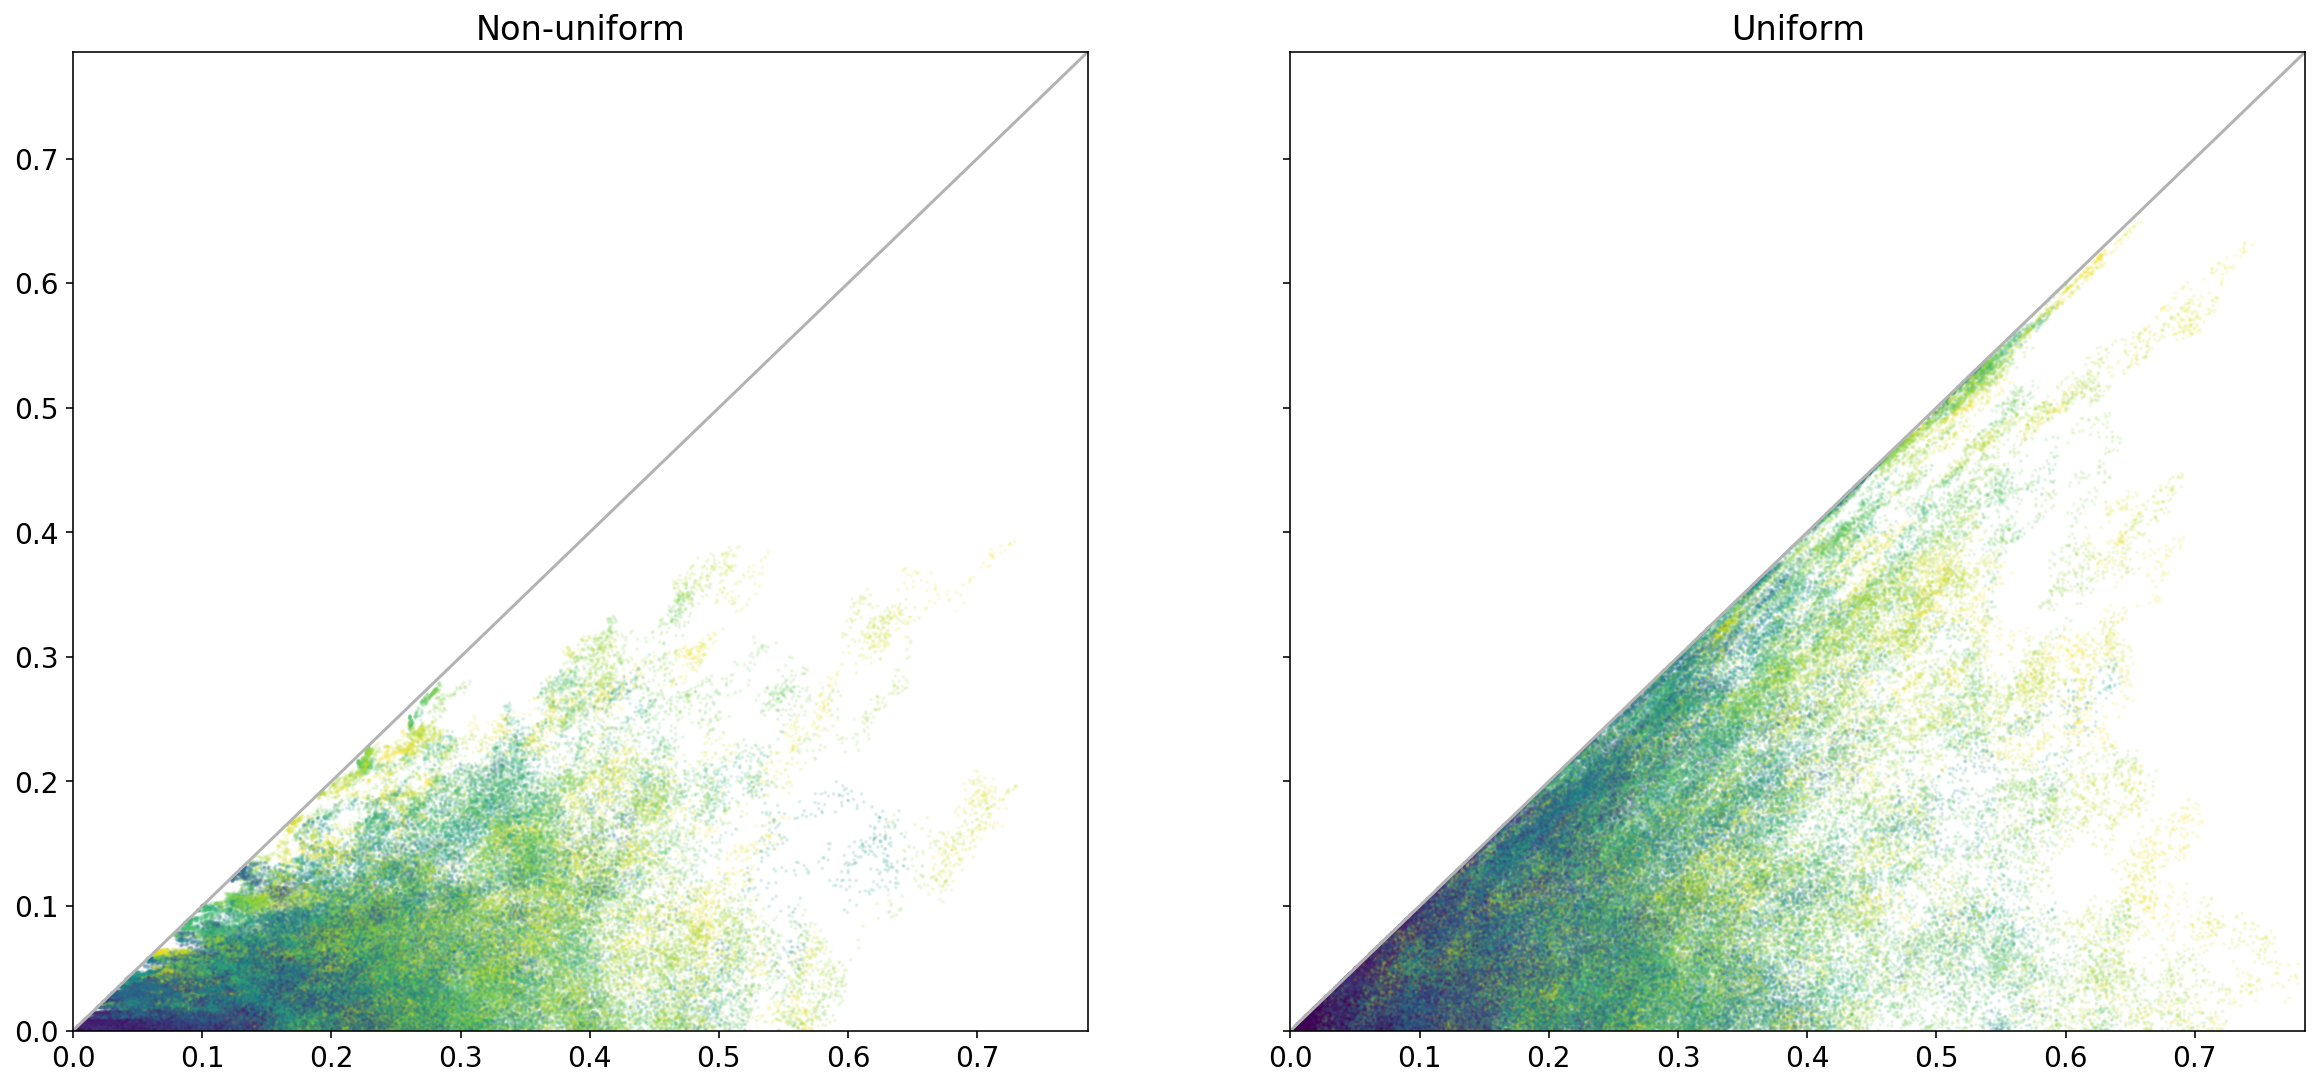

In [26]:
# Select colormap
cm = plt.get_cmap('viridis') 

maxdist = np.pi/4
nplots = 100
alpha = 0.1
markersize = 1.
fig = plt.figure(figsize=(20, 9))
ax1, ax2 = fig.subplots(1,2,sharey=True)

ax1.plot([0,maxdist],[0,maxdist],color=0.7*np.ones(3))
for ddq, ddv in zip(distq[:nplots], vdistq[:nplots]):
    ax1.scatter(ddq,ddv,s=markersize,c=cm(np.linspace(0,1,Nsteps)),alpha=alpha)
ax1.set_xlim((0,maxdist))
ax1.set_ylim((0,maxdist))
ax1.set_title("Non-uniform")

ax2.plot([0,maxdist],[0,maxdist],color=0.7*np.ones(3))
for ddq, ddv in zip(distquni[:nplots], vdistquni[:nplots]):
    ax2.scatter(ddq,ddv,s=markersize,c=cm(np.linspace(0,1,Nsteps)),alpha=alpha)
ax2.set_xlim((0,maxdist))
ax2.set_ylim((0,maxdist))
ax2.set_title("Uniform");

Notice that in the non-uniform plot the dark blue regions stretch out along the $x$-axis.

# APPENDIX

## Export to ParaView

In [13]:
import pyevtk
def exportQtoVTK(Q, prefix='Q', nouts=None):
    index = 0
    if not nouts:
        nouts = Q.shape[1]
    Nsteps = Q.shape[1]
    folder = "data/"
    colors = ['red','green','blue']
    for k in range(0,Nsteps,Nsteps//nouts):
        for d in range(3):
            filename = folder+prefix+"_"+colors[d]+str(index)
#             color_data = np.ones(Nruns,dtype=float)
            color_data = Q[:,k,1,d].copy()
    #         attached_data = (np.eye(3)[d]*np.ones(Nruns,dtype=float)[:,np.newaxis]).copy()
            pyevtk.hl.pointsToVTK(filename,Q[:,k,0,d].copy(),Q[:,k,1,d].copy(),Q[:,k,2,d].copy(),\
                              {'ypos':color_data})
        index = index + 1

ImportError: No module named 'pyevtk'

In [ ]:
exportQtoVTK(np.transpose(Q,(0,1,3,2)),prefix='Qshort',nouts=512)

In [ ]:
exportQtoVTK(Quni,prefix='Quni')